<a href="https://colab.research.google.com/github/AvokrichA/29092022/blob/main/%D0%94%D0%97_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Урок 9. Python применение продвинутых методов
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

userid: идентификатор игрока.

version = контрольная группа (gate_30 - ворота 30 уровня) и группа с перемещенными воротами (gate_40 - ворота 40 уровня).

sumgamerounds = количество раундов, сыгранных каждым игроком в течение первых 14 дней после установки.

retention_1 = Вернулся ли игрок в игру через 1 день после установки.

retention_7 = Вернулся ли игрок в игру через 7 дней после установки.

In [44]:
from scipy.stats import ttest_1samp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from scipy.stats import norm, t, kstest, shapiro
import statsmodels.api as sm
from matplotlib import pyplot as plt

import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, \
    kendalltau, f_oneway, kruskal


import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



In [4]:
data = pd.read_csv('/content/result_cookie_cats.csv')
data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [6]:
data.shape

(90189, 5)

In [7]:
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [8]:
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [9]:

data.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [11]:
data[data['sum_gamerounds']>0]

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


Посмотрим на группы отдельно

In [12]:

data[data['version']=='gate_30'].describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.470000e+04,44700.000000,44700.000000,44700.000000
mean,4.987564e+06,52.456264,0.448188,0.190201
std,2.881026e+06,256.716423,0.497314,0.392464
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505469e+06,5.000000,0.000000,0.000000
50%,4.983631e+06,17.000000,0.000000,0.000000
75%,7.481497e+06,50.000000,1.000000,0.000000
max,9.999710e+06,49854.000000,1.000000,1.000000


In [13]:
data[data['version']=='gate_40'].describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.548900e+04,45489.000000,45489.000000,45489.000000
mean,5.009073e+06,51.298776,0.442283,0.182000
std,2.885496e+06,103.294416,0.496663,0.385849
min,3.770000e+02,0.000000,0.000000,0.000000
25%,2.517171e+06,5.000000,0.000000,0.000000
50%,5.007329e+06,16.000000,0.000000,0.000000
75%,7.510762e+06,52.000000,1.000000,0.000000
max,9.999861e+06,2640.000000,1.000000,1.000000


Здесь можно заметить, что максимальное количество раундов в контрольной группе сильно больше, чем во второй . Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

In [14]:

v = data.\
    groupby('userid', as_index=False).\
    agg({'version': pd.Series.nunique})

In [15]:
v.head(10)

,userid,version
0,116,1
1,337,1
2,377,1
3,483,1
4,488,1
5,540,1
6,1066,1
7,1444,1
8,1574,1
9,1587,1


In [16]:
data.shape

(90189, 5)

Метрика: количество раундов, сыгранных каждым игроком в течение первых 14 дней после установки.

In [36]:
A = data.query('version == "gate_30"')
B = data.query('version == "gate_40"')
n1, n2 = A.shape[0], B.shape[0]

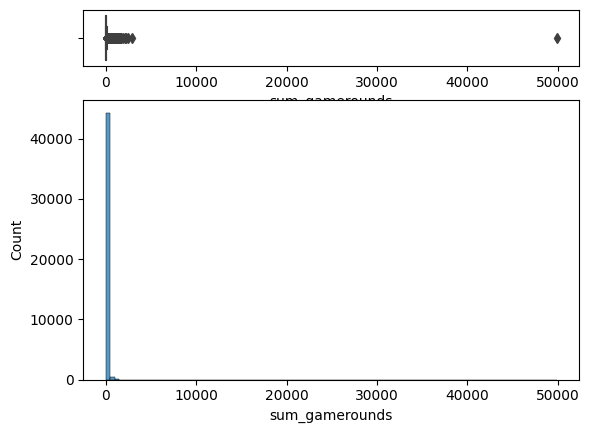

In [39]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(x=A['sum_gamerounds'], ax=ax[0]);
sns.histplot(A['sum_gamerounds'], bins=100, ax=ax[1]);

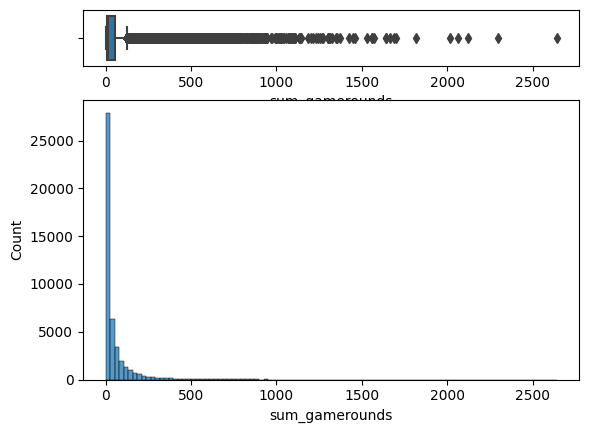

In [40]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(x=B['sum_gamerounds'], ax=ax[0]);
sns.histplot(B['sum_gamerounds'], bins=100, ax=ax[1]);

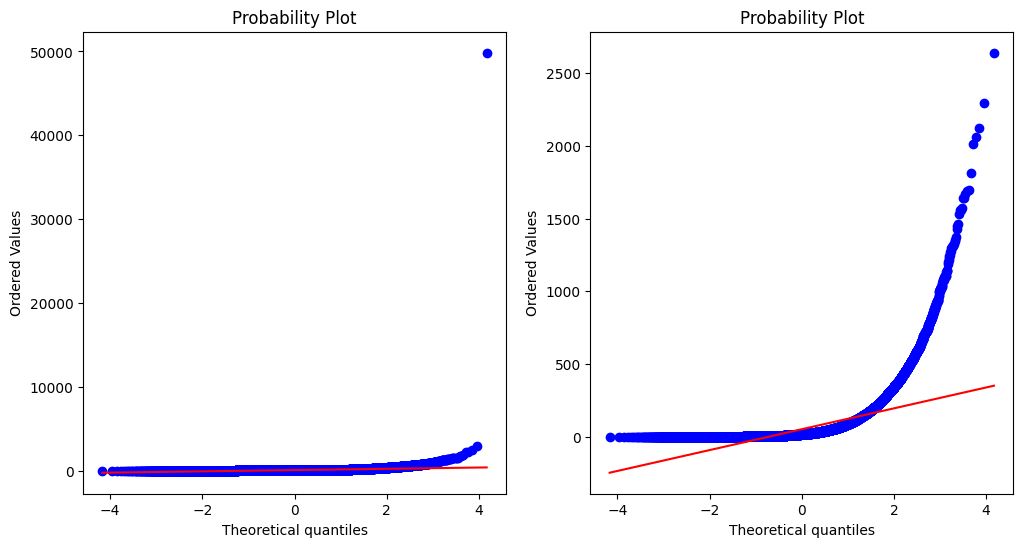

In [45]:
plt.figure(figsize = [6*2, 6])

plt.subplot(1, 2, 1)
norm = stats.probplot(A['sum_gamerounds'], dist="norm", plot=plt)

plt.subplot(1, 2, 2)
norm = stats.probplot(B['sum_gamerounds'], dist="norm", plot=plt)

**Проверка на нормальность:**

Для gate_30:

In [34]:

test_stat, pvalue = shapiro(data.loc[data["version"] == "gate_30", "sum_gamerounds"])
print("Test Stat = %.8f, p-value = %.8f" % (test_stat, pvalue))

Test Stat = 0.08805108, p-value = 0.00000000


In [ ]:
Для gate_40:

In [33]:
test_stat, pvalue = shapiro(data.loc[data["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.8f, p-value = %.8f" % (test_stat, pvalue))

Test Stat = 0.48256636, p-value = 0.00000000


p-value < 0.05, говорит о том,что предположение о нормальном распределении не верно, для обоих групп.

**Допущение однородности дисперсии:**

In [27]:
test_stat, pvalue = levene(data.loc[data["version"] == "gate_30", "sum_gamerounds"],
                            data.loc[data["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))


Test Stat = 0.5292, p-value = 0.4669


Исходя из полученных данных мы видим, что дисперсия однородна (p-value >0.05)

**Применение гипотез:**

Согласно «Нормальному распределению» и «Предположению об однородности дисперсии» показано, что первый контроль НЕ принимает нулевую гипотезу, а второй принимает её. Это означает, что мы должны использовать команду mannwtihneyu() для применения гипотезы.

Критерий Манна-Уитни основан на сравнении каждого наблюдения xi в первой выборке с каждым наблюдением yj в другой выборке. Общее количество попарных сравнений, которые можно сделать, равно nxny.1

In [26]:


test_stat, pvalue = mannwhitneyu(data.loc[data["version"] == "gate_30", "sum_gamerounds"],
                            data.loc[data["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 1024331250.5000, p-value = 0.0502


Вывод:

Так как p-value >0.05 то мы приманием нулевую гипотезу

Заключение и рекомендация.

Результат U-критерия Манна-Уитни, p-value рассчитано как 0,0502, и это означает, что нулевую гипотезу невозможно отклонить?Т.к. результаты для обоих групп(gate_30 и gate_40) были получены случайно.

Рекомендация:
 Увеличить размер выборки, это позволит, поднять мощность тестов по метрикам возвращения игроков в игру.